In [1]:
import os
import glob
import pandas as pd
import plotly
import plotly.express as px
from datetime import datetime
import time

In [2]:
gt_path = "/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gt_vqa_csv"
pred_path = "/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa"
output_path = "/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/results/frequency_of_wrong_prediction"
output_path_occur = "/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/results/occurrence_of_classes"

In [3]:
gt_csvs = glob.glob(
    os.path.join(
        gt_path,
        '*.csv'
    )
)

In [4]:
hist_data = []
wrong_pos_data_dict = {}
wrong_neg_data_dict = {}
total_data_dict = {}
occurrence_class = {}

for gt_csv in gt_csvs:
    gt_df = pd.read_csv(gt_csv, index_col=0)
    gt_df.dropna(how='all', axis=1, inplace=True)
    gt_df.dropna(how='all', axis=0, inplace=True)
    gt_df.index = gt_df.index.str.lower()
    gt_df.columns = gt_df.columns.str.lower()
    
    try:
        pred_df= pd.read_csv(
            os.path.join(pred_path, os.path.basename(gt_csv).replace('_', '-')),
            index_col=0
        )
    except Exception as e:
        print(e)
        continue
    
    pred_df.dropna(how='all', axis=1, inplace=True)
    pred_df.dropna(how='all', axis=0, inplace=True)
    pred_df.index = pred_df.index.str.lower()
    pred_df.columns = pred_df.columns.str.lower()
    
    for col in gt_df.columns:
        for row in gt_df.index:
            gt_val = str(gt_df[col][row]).strip()
            if gt_val == '-1':
                gt_val = 1
            try:
                pred_val = str(pred_df[col.replace('_', '-')][row]).strip()
            except Exception as e:
                # print(e)
                continue
            if gt_val != '0':
                if row not in occurrence_class.keys():
                    occurrence_class[row] = 0
                occurrence_class[row] += 1
            if gt_val != pred_val:
                hist_data.append(row)
                if gt_val == '0':
                    if row not in wrong_pos_data_dict.keys():
                        wrong_pos_data_dict[row] = 0
                    wrong_pos_data_dict[row] += 1
                else:
                    if row not in wrong_neg_data_dict.keys():
                        wrong_neg_data_dict[row] = 0
                    wrong_neg_data_dict[row] += 1
                    
            if row not in total_data_dict.keys():
                total_data_dict[row] = 0
            total_data_dict[row] += 1
            


[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-19-segment-4.csv'
[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-20-segment-5.csv'
[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-19-segment-2.csv'
[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-20-segment-1.csv'
[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-17-segment-1.csv'
[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-17-segment-3.csv'
[Errno 2] No such file or directory: '/Users/imrankabir/Desktop/research/vqa_accessibility/result_generator/data/gpv_vqa/video-18-

In [6]:
drop_row_list = [
    'car',
    'chair',
    'curb',
    'fence',
    'fire hydrant',
    'fountain',
    'gate',
    'person with a disability',
    'roadside parking',
    'sidewalk',
    'sidewalk pits',
    'trash on roads',
    'wet surface',
    'wheelchair',
    'white cane',
]

In [7]:
hist_data_dict = {
    'Class': [],
    'False Positive': [],
    'False Negative': [],
    'False Prediction': []
}

final_occurrence_class = {
    'Class': [],
    'Occurrences': []
}

for key in occurrence_class.keys():
    final_occurrence_class['Class'].append(key.title())
    final_occurrence_class['Occurrences'].append(occurrence_class[key])

for key in total_data_dict.keys():
    if key not in drop_row_list:
        continue
    if key in wrong_pos_data_dict.keys():
        fp_val = wrong_pos_data_dict[key] / total_data_dict[key]
    else:
        fp_val = 0
        
    if key in wrong_neg_data_dict.keys():
        fn_val = wrong_neg_data_dict[key] / total_data_dict[key]
    else:
        fn_val = 0
        
    hist_data_dict['Class'].append(key.title())
    hist_data_dict['False Positive'].append(fp_val)
    hist_data_dict['False Negative'].append(fn_val)
    hist_data_dict['False Prediction'].append(fp_val + fn_val)

In [8]:
occur_df_perc = pd.DataFrame.from_dict(final_occurrence_class)
occur_df_perc = occur_df_perc.sort_values(by=['Occurrences'])
occur_df_perc

,Class,Occurrences
2,Train Platform,1
7,Elevator,1
57,Barrier Stump,2
45,Flush Door,2
58,Chair,4
...,...,...
4,White Cane,276
18,Road,316
0,Sidewalk,415
9,Person With A Disability,453


In [9]:
hist_df_perc = pd.DataFrame.from_dict(hist_data_dict)
hist_df_perc = hist_df_perc.sort_values(by=['False Prediction'])
hist_df_perc.head()

,Class,False Positive,False Negative,False Prediction
0,Car,0.039400,0.078799,0.118199
1,Chair,0.127580,0.003752,0.131332
4,Fire Hydrant,0.138837,0.022514,0.161351
8,Roadside Parking,0.227017,0.024390,0.251407
9,Sidewalk,0.116323,0.180113,0.296435


In [10]:
hist_df_perc = pd.melt(
    hist_df_perc, id_vars=['Class'],
    var_name = 'Types',
    value_vars = ["False Positive", "False Negative"],
    value_name = 'Wrong Prediction (Probability)'
)
hist_df_perc.set_index(['Class'], inplace=True)
hist_df_perc['Class'] = hist_df_perc.index
hist_df_perc

,Types,Wrong Prediction (Probability),Class
Class,,,
Car,False Positive,0.039400,Car
Chair,False Positive,0.127580,Chair
Fire Hydrant,False Positive,0.138837,Fire Hydrant
Roadside Parking,False Positive,0.227017,Roadside Parking
Sidewalk,False Positive,0.116323,Sidewalk
Trash On Roads,False Positive,0.281426,Trash On Roads
White Cane,False Positive,0.212008,White Cane
Wet Surface,False Positive,0.446529,Wet Surface
Curb,False Positive,0.339587,Curb


In [11]:
fig1 = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig1.write_image(os.path.join(output_path, ".garbage.pdf"))

In [ ]:
time.sleep(10)

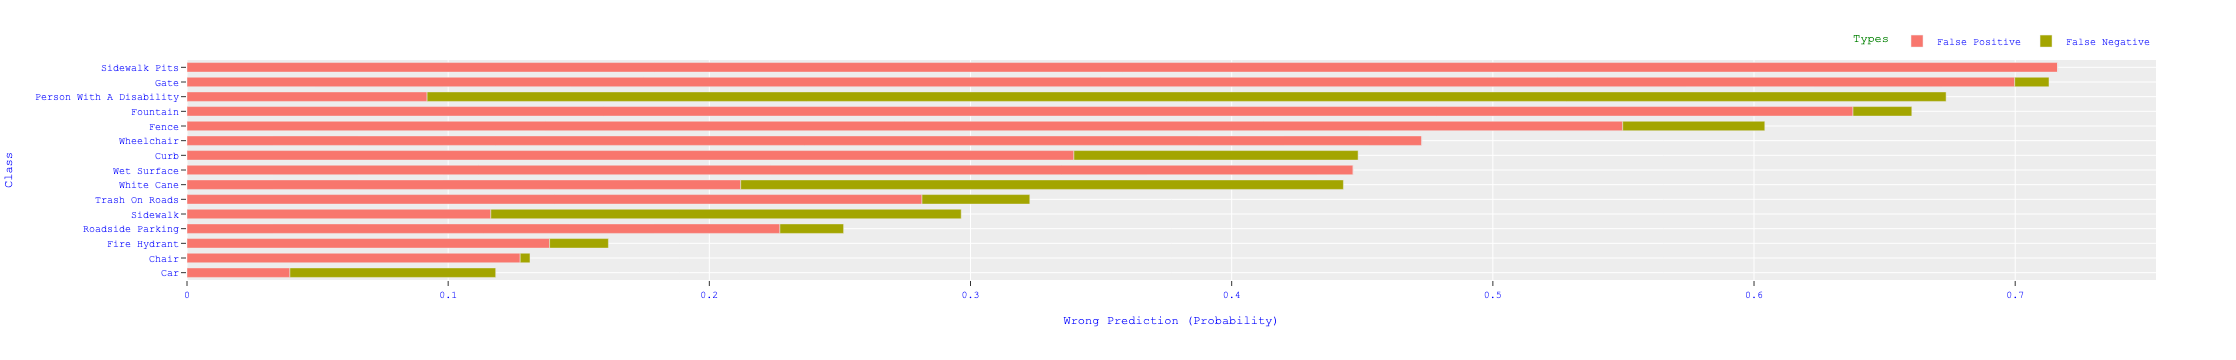

In [14]:
fig = px.bar(
    hist_df_perc, 
    y='Class', 
    x='Wrong Prediction (Probability)', 
    color='Types',
    template="ggplot2", 
    orientation='h', 
    width=400, 
    height=300
)
fig.update_traces(width=0.65)
fig.update_yaxes(dtick=hist_df_perc['Class'])
fig.update_layout(
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green",
    font=dict(size=10),
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

filename = f'{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}.pdf'

fig.write_image(
    os.path.join(output_path, filename), 
    format='pdf'
)
fig.show()

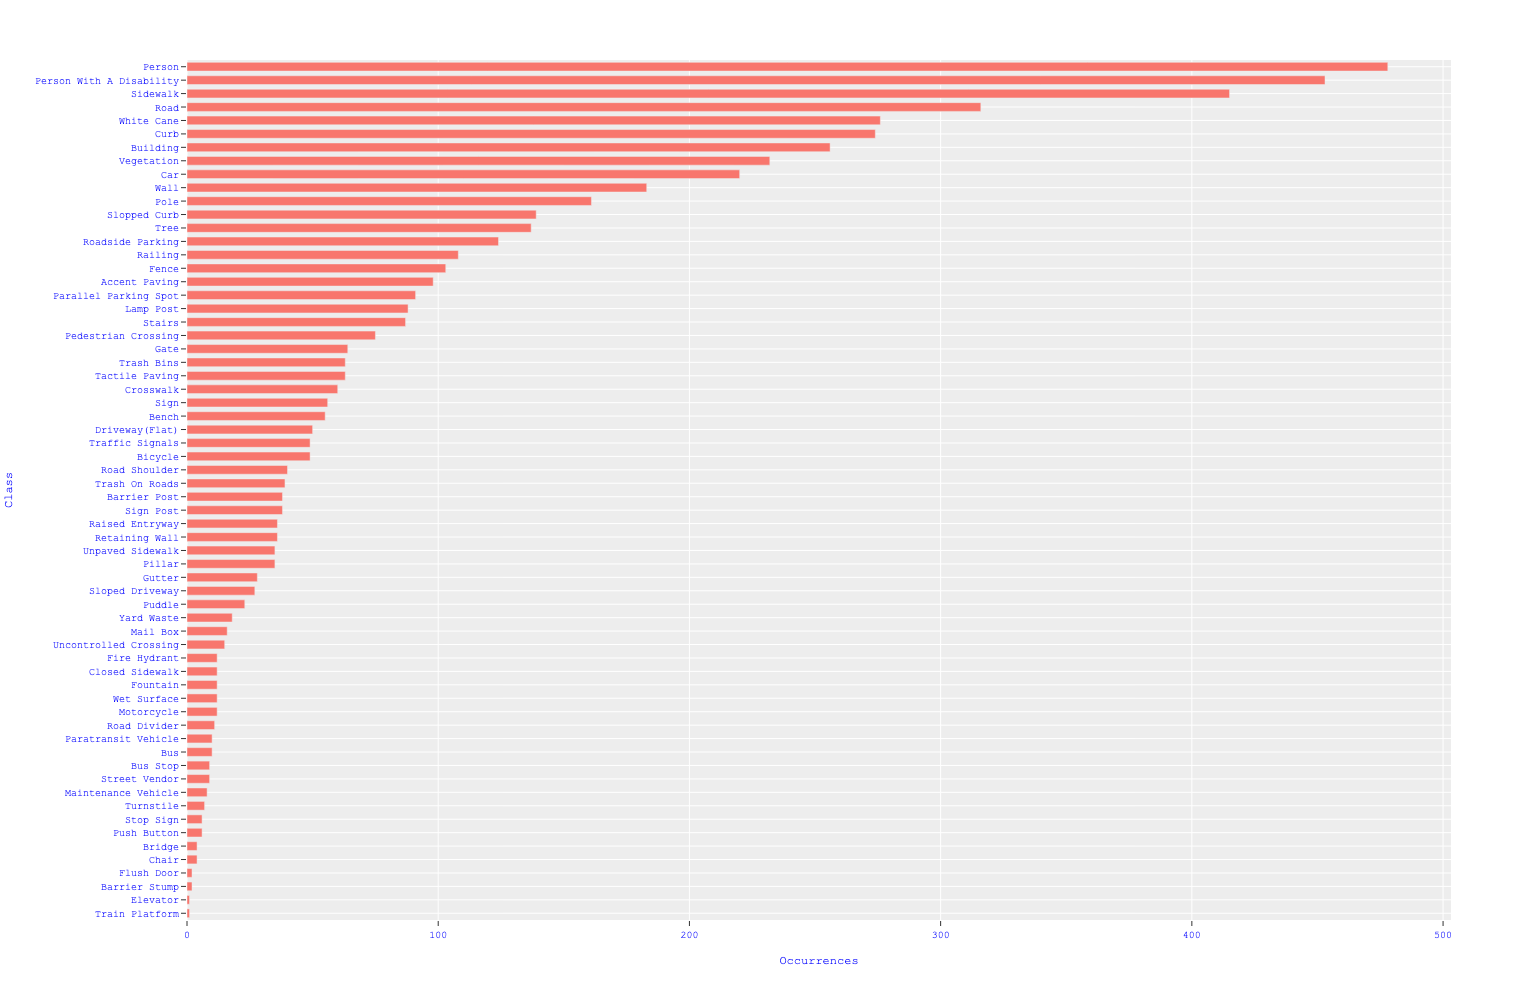

In [10]:

fig = px.bar(
    occur_df_perc, 
    y='Class', 
    x='Occurrences', 
    template="ggplot2", 
    orientation='h', 
    width=400, 
    height=1000
)
fig.update_traces(width=0.65)
fig.update_yaxes(dtick=occur_df_perc['Class'])
fig.update_layout(
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green",
    font=dict(size=10),
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

# filename = f'{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}.pdf'

fig.write_image(
    os.path.join(output_path_occur, filename), 
    format='pdf'
)
fig.show()

In [11]:
# order = list(hist_data_dict.keys())

In [12]:
# hist_dict = {'wrong prediction': hist_data}
# hist_df = pd.DataFrame.from_dict(hist_dict)

In [13]:
# fig = px.histogram(hist_df, x="wrong prediction", template="ggplot2",
                   # category_orders={"wrong prediction": order})
# fig.show()